# Conversion Rate Optimization 

`Goal`: \
Optimizing conversion rate is likely the most common work of a data scientist, and rightfully so.
The data revolution has a lot to do with the fact that now we are able to collect all sorts of data about people who buy something on our site as well as people who don't. This gives us a tremendous opportunity to understand what's working well (and potentially scale it even further) and what's not working well (and fix it).

`Challenge Description`:\
We have data about users who hit our site: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site).

`Variable Description`:
* country : user country based on the IP address
* age : user age. Self-reported at sign-in step
* new_user : whether the user created the account during this session or had already an account and simply came back to the site
* source : marketing channel source
    * Ads: came to the site by clicking on an advertisement
    * Seo: came to the site by clicking on search results
    * Direct: came to the site by directly typing the URL on the browser
* total_pages_visited: number of total pages visited during the session. This is a proxy for time spent on site and engagement during the session.
* converted: this is our target variable. 1 means they converted within the session, 0 means they left without buying anything. The company goal is to increase conversion rate: # conversions / total sessions.

`This project is to`:
* Predict conversion rate 
* Come up with recommendations for the product team and the marketing team to improve conversion rate

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
np.warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('conversion_data.csv')

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB
None


In [4]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


# 1. Exploratory Data Analysis

## 1.1 Target Variable

In [5]:
df['converted'].value_counts()

0    306000
1     10200
Name: converted, dtype: int64

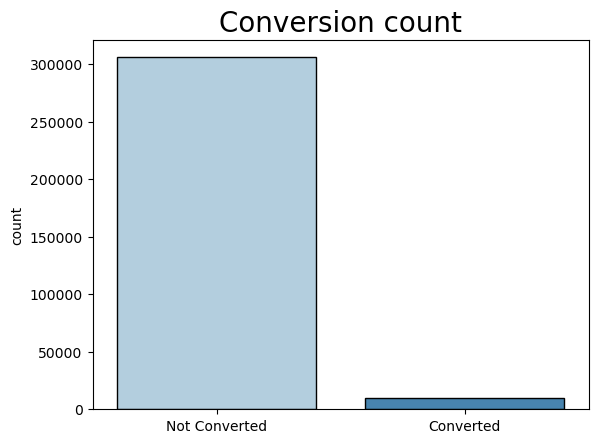

In [6]:
ax = sns.countplot(data=df, x='converted',palette='Blues',edgecolor='Black');
ax.set_xticklabels(['Not Converted','Converted']);
plt.xlabel(None);
plt.title('Conversion count',fontdict={'fontsize':20});

* We can see that the class is unbalanced
* We might need to use some techniques to deal with unbalanced datasets for machine learning

## 1.2 Number of new user

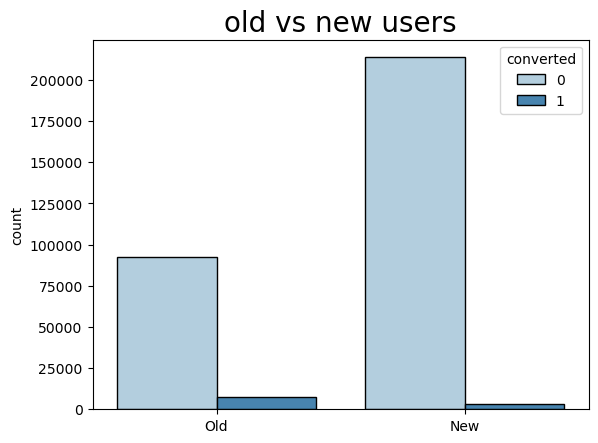

In [7]:
ax = sns.countplot(data=df, 
                   x='new_user', 
                   palette='Blues', 
                   edgecolor='Black',
                  hue='converted')
ax.set_xticklabels(['Old', 'New'])
plt.xlabel(None)
plt.title('old vs new users', fontdict={'fontsize': 20});

In [8]:
user = df.groupby(
    'new_user')['converted'].mean().to_frame().reset_index().sort_values(
        by='converted', ascending=False)

user['new_user'] = user['new_user'].map({0:'old',1:'new'})
user.columns = ['user_status','conversion_rate']
user

# 0 = old
# 1 = new

,user_status,conversion_rate
0,old,0.072002
1,new,0.014021


**Insights**:
* More new users coming to our sit (makes sense)
* Customers who already have accounts (old customers) are more likely to convert
* Reasons:
    * Customers who already have accounts with the company have probably interacted with it and may have grown to trust it and its products. This might encourage them to buy something.
    * Customers who already have an account with the business are more comfortable making purchases because they are familiar with the company's website, checkout process, and policies.
    * Customers who already have an account are more likely to convert when companies use their data to tailor the customer experience and provide relevant recommendations.

## 1.3 Marketing Channel (where did they come from)

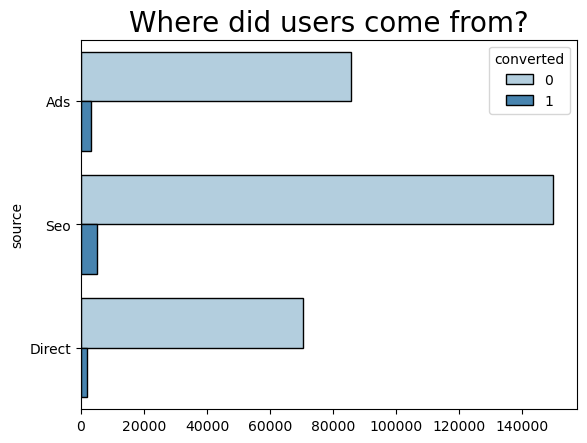

In [9]:
ax = sns.countplot(
    data=df,
    y='source',
    palette='Blues',
    edgecolor='Black',
    hue='converted'
)
plt.xlabel(None)
plt.title('Where did users come from?', fontdict={'fontsize': 20});

#SEO: search engines

* We can see that most users came from the site by clicking on search results(google/bing etc) some users came from Ads
* less people came to site by typing URL (which is common)

**what about conversion rate of each channel?**

In [10]:
source = df.groupby('source')['converted'].mean().to_frame().reset_index().sort_values(
    by='converted', ascending=False)

source.columns = ['source','converion_rate']
source


,source,converion_rate
0,Ads,0.034483
2,Seo,0.032895
1,Direct,0.028169


**Insights**:
* We can see that Ads has a slightly higher conversion rate 
* Customers who come directly to our site have the lowest conversion rate
    * **reasons could be that**:
        * Customers who directly come to our site `might not have context or understanding` of the company's products or services, and therefore, they are less likely to make a purchase (converted)
        * They might be unfamiliar with `website layout` or the layout is bad
        * They may not have `completed research or comparisons` with other companies, which can lower their conversion rate.
        * etc...
* **Improvement**:
    * To increase the likelihood of conversion for customers who access the site directly, consider strategies such as `supplying more information about the company and its offerings`, `improving the site's organization and navigation`, and `promoting the brand through marketing and outreach`

## 1.4 Age

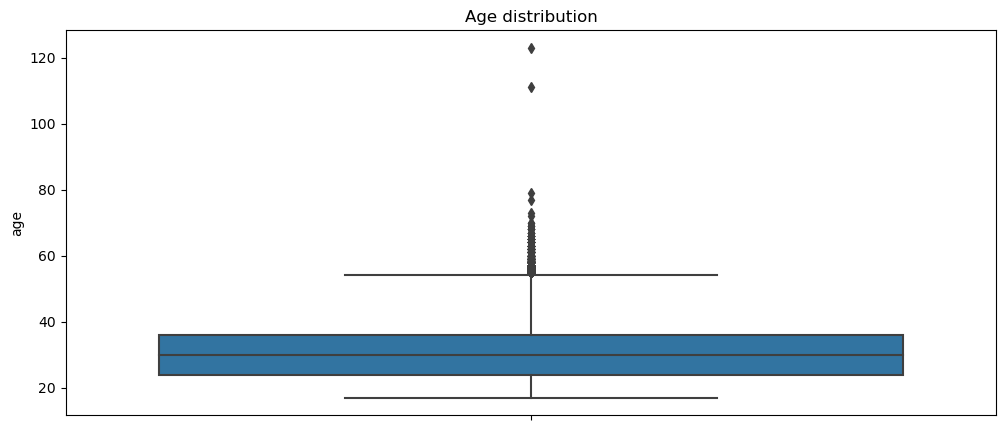

In [11]:
plt.figure(figsize=(12,5))
sns.boxplot(y='age',data=df);
plt.title('Age distribution');

* We can see that our targeted customers are around age 30; at least customers who are likely to visit our website
* there are people over 100 age?

In [12]:
df = df[df['age'] <= 100] #get rid of 100+ age customers

**What age group has the highest conversion rate?**

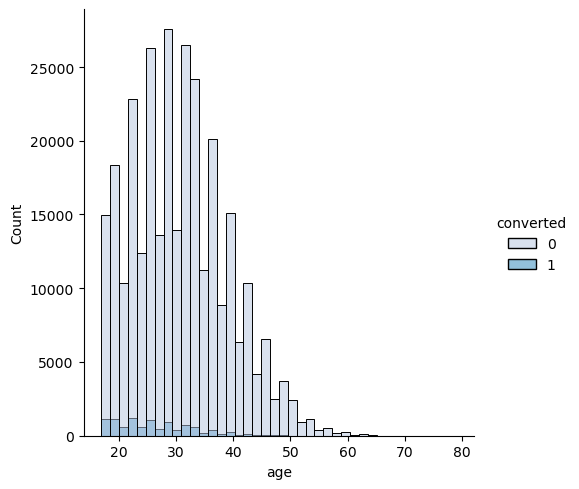

In [13]:
sns.displot(x='age',
            data=df,
            bins=40,
            kde=False,
            hue='converted',
            palette='PuBu',
            edgecolor='Black');

* It is right Skewed. 
* Users who are less than 40 are more likely to convert

## 1.5 pags visited

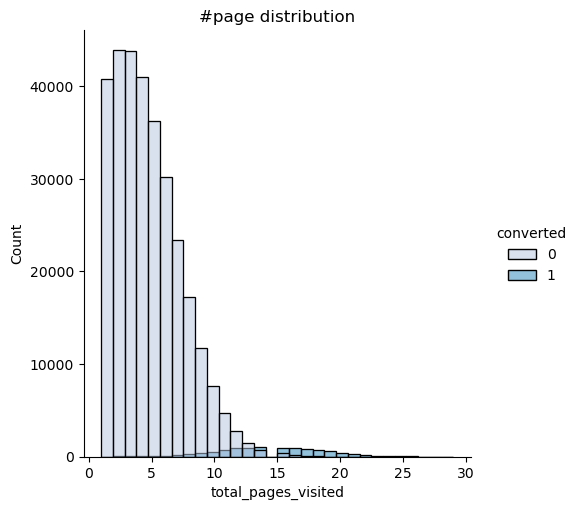

In [14]:
sns.displot(x='total_pages_visited',bins=30,hue='converted',data=df,palette='PuBu',edgecolor='Black');
plt.title('#page distribution');

* It makes sense that it is right skewed (vast majority of people visit fewer than 10 pages)
* People who visited 10 + pages are more likely to convert
    * The more you engage with websites and the more likely you will convert -> Nearly all people who visited more than 13 are converted
    * We can see that there is a strong correlation with this (maybe we have great content or customer services to make them convert)
    * SO, we could try to attract people to visit more pages

## 1.6 Country

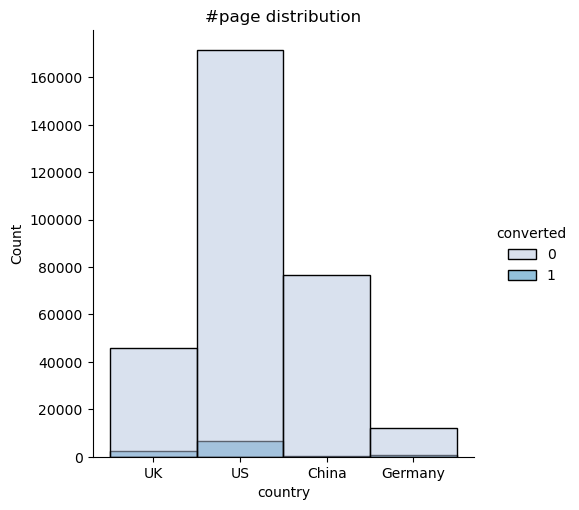

In [15]:
sns.displot(x='country',bins=30,hue='converted',data=df,palette='PuBu',edgecolor='Black');
plt.title('#page distribution');


* Chinese users barely converted, which need to be investigated

# 2. Modeling

## 2.1 Prediction

<div class="mark">
`Unbalanced label`</div><i class="fa fa-lightbulb-o "></i>

In [16]:
print(
    'percent of clicks:',
    round(
        (df['converted'].value_counts()[1] / df['converted'].value_counts()[0])
        * 100, 2), '%')

percent of clicks: 3.33 %


use stra-cross-validation

**Deal with unbalanced datasets**:
* Change threshold or assign class weights. However, I think this dataset is very unbalanced (3% converted) and therefore changing these two techniques might not be very effective
* Alternatively, we can use `SMOTE` and `bagging` (use all converted class and portion of not converted class)

**Models**

* This is a classification model (supervised)
* I chose the following models for predictions

    * Logistic Regression
        * White box and easy to interpret
    * XG boost
        * Fast and can be used to display the feature importance
    * Random Forest 
        * Same as above and can be used to build a Partial dependence plot

Convert into dummies

In [17]:
#convert country, source into dummies

X = pd.get_dummies(df.drop('converted',axis=1),drop_first=True)
y = df['converted']

Train Test Split

In [18]:
# Let's split them into training and testing set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

Scale numeric data

In [19]:
# Scaled our data for better precision

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train[['age', 'total_pages_visited'
         ]] = scaler.fit_transform(X_train[['age', 'total_pages_visited']])

X_test[['age', 'total_pages_visited'
        ]] = scaler.transform(X_test[['age', 'total_pages_visited']])


In [20]:
#Import kfold for model evluation
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

#metrics
from sklearn.metrics import f1_score,accuracy_score, classification_report

#Grid search for best parameters
from sklearn.model_selection import GridSearchCV, ParameterGrid

#pipeline
from sklearn.pipeline import Pipeline

#oversample (unbalanced dataset)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

#models
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.linear_model import LogisticRegression


**Oversample**

In [21]:
# Create a SMOTE transformer
smote = SMOTE(random_state=42,sampling_strategy='auto')

# Oversample the training data
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

**Random Forests**

In [22]:
# Train a classifier on the oversampled data
clf = RandomForestClassifier(min_impurity_decrease=0.01,
                            n_estimators=120)
clf.fit(X_train_oversampled, y_train_oversampled)


RandomForestClassifier(min_impurity_decrease=0.01, n_estimators=120)

In [23]:
# Test the classifier on the test data
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.92      0.95     61200
           1       0.27      0.93      0.42      2040

    accuracy                           0.92     63240
   macro avg       0.63      0.92      0.69     63240
weighted avg       0.97      0.92      0.94     63240



In [24]:
# #can try using gridsearch(this will take a while)
# # Create a pipeline that includes StandardScaler, SMOTE, and RandomForestClassifier
# pipe = imbpipeline([('smote', SMOTE(random_state=42)),
#                     ('classifier', RandomForestClassifier())])

# #RepeatedStratifiedKFold object that will be used as the cross-validation generator in the grid search
# stratified_kfold = RepeatedStratifiedKFold(n_splits=5,
#                                            n_repeats=5,
#                                            random_state=42)

# # Define the hyperparameters to tune
# param_grid = {'smote__k_neighbors': [3, 5, 7], 
#               'smote__sampling_strategy': [0.1, 0.2, 0.5],
#              'classifier__n_estimators':[50,80,100,120],
#              'classifier__max_depth':[None,5,10],
#              'classifier__max_features':['auto','sqrt','log2']}

# # Use GridSearchCV to perform the grid search
# grid_search = GridSearchCV(estimator=pipe, 
#                            param_grid=param_grid, 
#                            scoring='accuracy',
#                            cv=stratified_kfold)


# # Fit the grid search object to the training data
# grid_search.fit(X_train, y_train)

# grid_search.score(X_test,y_test)

**Logit Regression**

In [25]:
# Train a classifier on the oversampled data
lr = LogisticRegression()
lr.fit(X_train_oversampled, y_train_oversampled)


LogisticRegression()

In [26]:
# Test the classifier on the test data
print(classification_report(y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     61200
           1       0.35      0.93      0.51      2040

    accuracy                           0.94     63240
   macro avg       0.67      0.94      0.74     63240
weighted avg       0.98      0.94      0.95     63240



**XG Boost**

In [27]:
# Train a classifier on the oversampled data
xg = xgboost.XGBClassifier()
xg.fit(X_train_oversampled, y_train_oversampled);


In [28]:
# Test the classifier on the test data
print(classification_report(y_test, xg.predict(X_test)))


              precision    recall  f1-score   support

           0       0.99      0.98      0.99     61200
           1       0.55      0.84      0.67      2040

    accuracy                           0.97     63240
   macro avg       0.77      0.91      0.83     63240
weighted avg       0.98      0.97      0.98     63240



**XG boost is the best model for prediction**
* High f1-score in general
* Precision is higher

## 2.2 Insights

### 2.2.1 insights (logistic)

In [29]:
import statsmodels.api as sm

In [30]:
model = sm.OLS(y,X).fit()

In [31]:
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:              converted   R-squared (uncentered):                   0.321
Model:                            OLS   Adj. R-squared (uncentered):              0.321
Method:                 Least Squares   F-statistic:                          1.866e+04
Date:                Sun, 18 Dec 2022   Prob (F-statistic):                        0.00
Time:                        19:37:33   Log-Likelihood:                      1.5542e+05
No. Observations:              316198   AIC:                                 -3.108e+05
Df Residuals:                  316190   BIC:                                 -3.107e+05
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

*All have p values less than 0.05 (all significant and they are likely to have an impact on the outcome*

In [32]:
#base level
cate = df.select_dtypes(['object']).astype('category')
print(cate.apply(lambda x: x.cat.categories[0]))

country    China
source       Ads
dtype: object


**Insights**:
- we can see that all variables are important in predicting clicks
- age, new_user, source_direct, source_seo are all negative (source_ in comparison to their base level `ads`)
    - typically, older people is less likely to click 
    - newer user is less likely to click
        - this makes sense because loyal customers love our products and therefore more likely to click
    - direct and seo performed worse than ads in general
        - mkt department could invest more in ads to generate clicks (note: it could also mean ads might have clickbait and we need to pay attention to north star metric (conversion rate):how many people eventually convert to our customers to guide our decision
- all countries doing great compared to China 
    - visualization also informs us that china clicks aren't ok and we need to investigate there


**Visualize the feature weights**

In [33]:
lr = LogisticRegression().fit(X,y)

In [34]:
weights = pd.Series(lr.coef_[0], index=X.columns.values)

In [35]:
tb = weights.sort_values(ascending=False).to_frame('weights').reset_index()
tb.columns = {'variable','weight'}

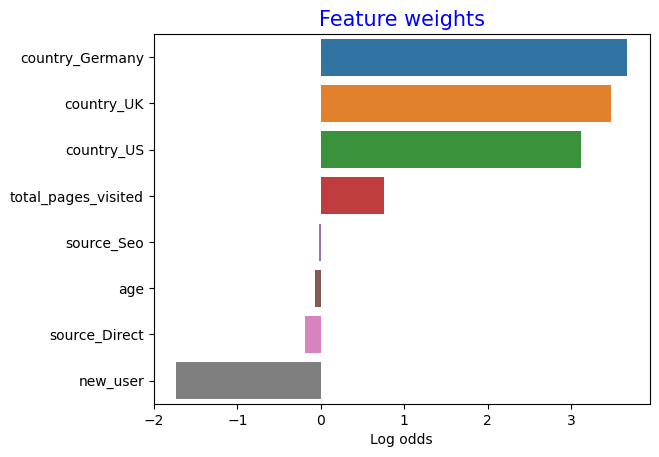

In [36]:
sns.barplot(data=tb, x='variable',y='weight');
plt.title('Feature weights',fontsize=15,color='blue')
plt.xlabel('Log odds')
plt.ylabel(None);

***background***: what is odd?\
`odds = P(event occurring) / P(event not occurring)`
* The log odds is a measure of the odds of an outcome occurring. The odds is defined as the probability of the outcome occurring divided by the probability of the outcome not occurring.

* A log odds of 0 indicates that the odds of the outcome occurring are equal to the odds of the outcome not occurring. In other words, there is an equal chance of the outcome occurring or not occurring.

* A positive log odds indicates that the odds of the outcome occurring are greater than the odds of the outcome not occurring. In other words, there is a higher probability of the outcome occurring.

* A negative log odds indicates that the odds of the outcome occurring are less than the odds of the outcome not occurring. In other words, there is a lower probability of the outcome occurring.

* The magnitude of the log odds tells you the strength of the relationship between the predictor variable and the outcome. For example, a log odds of 1 is stronger than a log odds of 0.5, which is in turn stronger than a log odds of 0.1.

**Insights**:
* If the p-value of a feature coefficient is smaller than 0.05, it indicates that the coefficient is statistically significant and that the corresponding predictor variable is likely to have an effect on the outcome. This means that a unit change in the predictor variable is likely to be associated with a change in the log odds of the outcome.
    * For example, the coefficient for the age predictor variable is -0.0023 and the p-value is smaller than 0.05, it means that, holding everything else constant, a unit increase in age is associated with a 0.0023 decrease in the log odds of making a purchase(converting). 

### 2.2.2 trees

- xg boost and random forests are very similar
- we will use xg to extract insights

In [37]:
xg.fit(X,y);

In [38]:
from xgboost import plot_importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

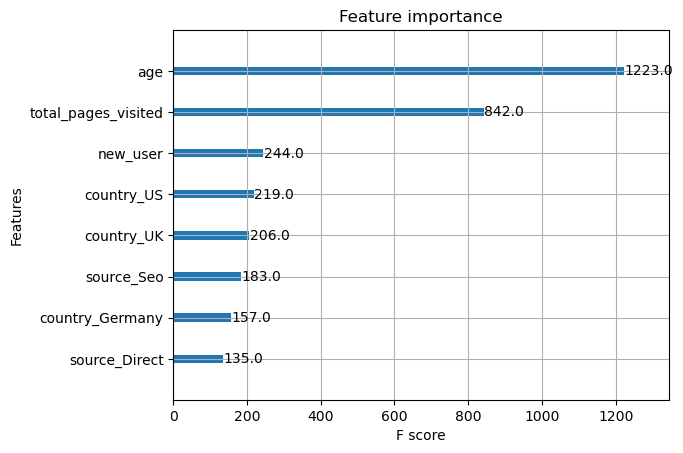

In [39]:
plot_importance(xg)

**Insights**:
* The graph helps us understand which features are the most important for making accurate predictions with the model.
* The model is being used to predict conversion rate, and the plot_importance function shows that the most important. features are the customer's age, the business may want to focus on this feature to identify patterns or trends in the data.
* Additionally, we can focus on the most important features that can help us streamline our model and make it more efficient. By only using the most important features, we can reduce the complexity of the model and potentially improve its performance. This can be especially useful if we are getting larger datasets or have limited resources for training and deploying your model.

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from graphviz import Source

In [52]:
clf = DecisionTreeClassifier(class_weight='balanced',min_impurity_decrease=0.001)
clf.fit(X,y)

DecisionTreeClassifier(class_weight='balanced', min_impurity_decrease=0.001)

class_weight='balanced' can help the classifier to better handle the imbalanced classes and improve the overall performance of the model.

In [53]:
tree.export_graphviz(clf,
                    out_file='tree.dot',
                    feature_names=X.columns.values,
                    filled=True,
                    rounded=True,
                    special_characters=True,
                    proportion=True,
                    rotate=True)

s = Source.from_file('tree.dot')

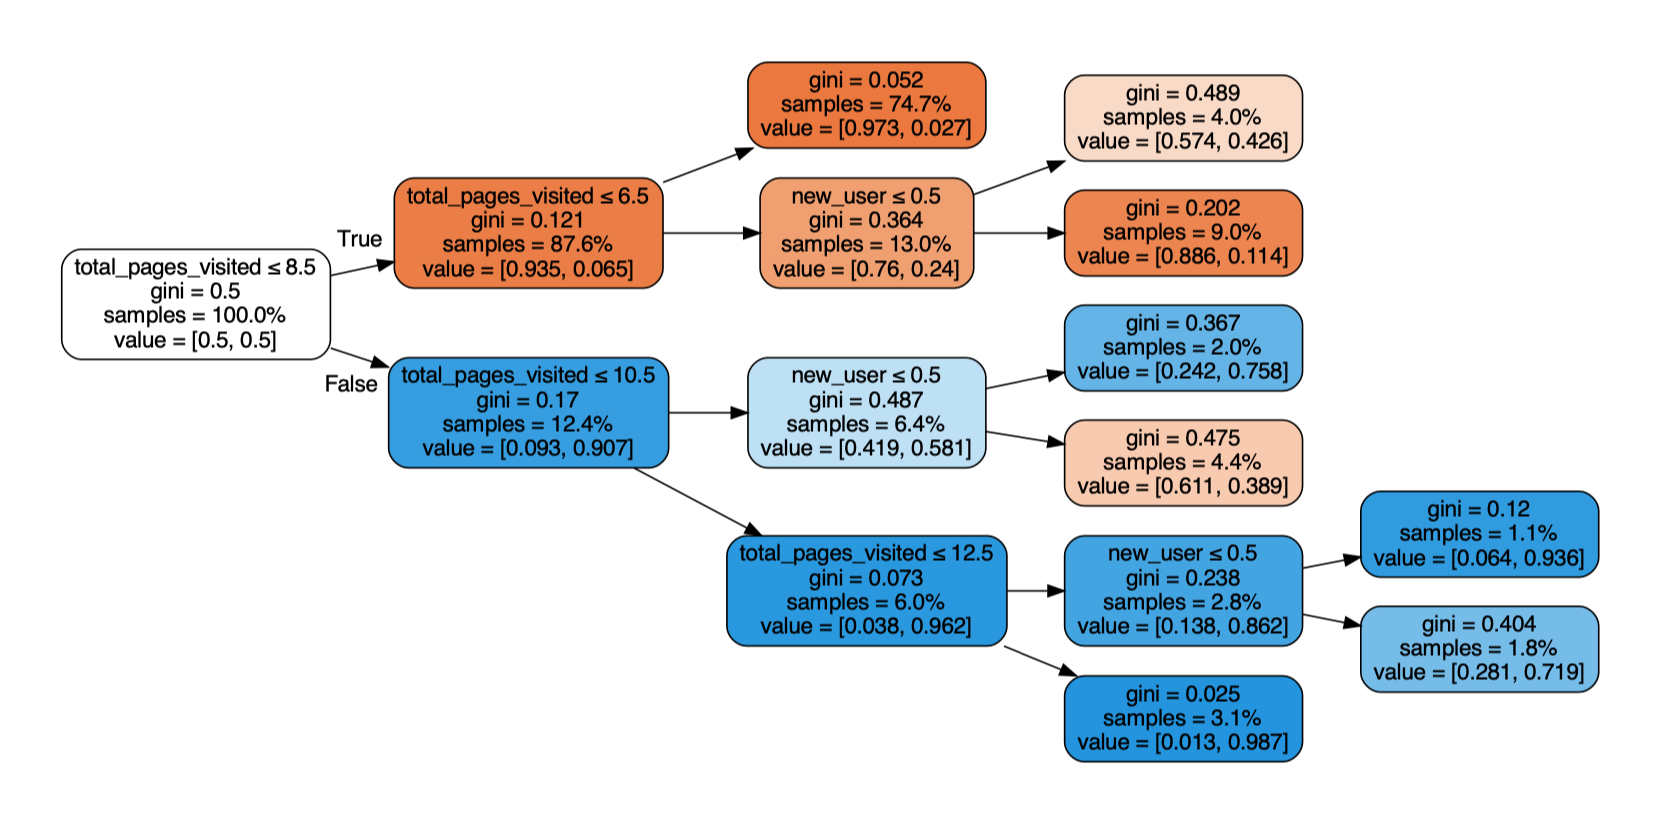

**Insights**:
In general, it appears that older users who visited between 6.5 and 8.5 pages have a high likelihood of converting, at 88.6%. This segment is performing well, as it represents 9% of the total dataset. However, customers who visited fewer than 8.5 pages generally have a lower likelihood of converting. On the other hand, those who visited more than 10.5 pages, which is a smaller segment comprising 6% of the total population, have a very high likelihood of converting, at 96.2%.